In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False


In [2]:
full_df = pd.read_csv('../../data/processed/downsampled/continuous_data.csv', index_col=[0])
labels = ['Cooler condition', 'Valve Condition', 'Internal pump leakage',
           'Hydraulic accumulator / bar', 'stable flag']
X = full_df.drop(columns=labels)
y = full_df['Internal pump leakage']

In [3]:
full_df

,CE,CP,EPS1_d,FS1_d,FS2_d,PS1_d,PS2_d,PS3_d,PS4_d,PS5_d,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve Condition,Internal pump leakage,Hydraulic accumulator / bar,stable flag
Cycle ID,,,,,,,,,,,,,,,,,,,,,
0,47.202,2.184,2411.6,8.990,10.179,151.47,125.500,2.305,0.000,9.936,...,35.570,40.961,38.320,30.363,0.604,3,100,0,130,1
0,47.273,2.184,2936.6,0.001,10.176,191.46,0.430,0.000,0.000,9.974,...,35.492,40.949,38.332,30.375,0.605,3,100,0,130,1
0,47.250,2.184,2656.2,0.005,10.163,179.09,0.133,0.000,0.000,9.984,...,35.469,40.965,38.320,30.367,0.611,3,100,0,130,1
0,47.332,2.185,2949.4,0.000,10.167,191.43,0.000,0.000,0.000,9.947,...,35.422,40.922,38.324,30.367,0.603,3,100,0,130,1
0,47.213,2.178,2945.8,0.000,10.167,191.36,0.000,0.000,0.000,9.964,...,35.414,40.879,38.332,30.379,0.608,3,100,0,130,1
0,47.372,2.188,2945.8,0.000,10.159,191.19,0.000,0.000,0.000,10.009,...,35.320,40.879,38.324,30.379,0.608,3,100,0,130,1
0,47.273,2.177,2945.8,0.000,10.182,191.32,0.000,0.000,0.000,9.971,...,35.227,40.828,38.348,30.367,0.608,3,100,0,130,1
0,47.438,2.180,2947.6,0.000,10.174,191.44,0.000,0.000,0.000,9.939,...,35.242,40.812,38.332,30.367,0.617,3,100,0,130,1
0,46.691,2.151,2945.6,0.001,10.161,191.30,0.000,0.000,0.000,9.977,...,35.160,40.809,38.336,30.375,0.619,3,100,0,130,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20d59c950>,
      dtype=object)

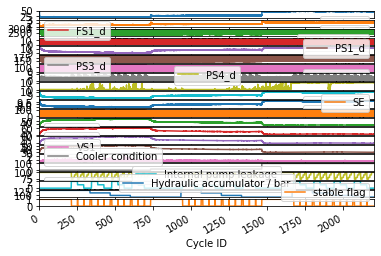

In [4]:
full_df.plot(subplots=True)
#plt.savefig('../plots/vis_200_cycles.pdf')

use code from tensorflow tutorial on multivariate time series analysis
https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_model

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        print(end_index)
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    print(data)
    return np.array(data), np.array(labels)


test on smaller dataset cause memory issues

In [6]:
past_history = 60*20 #20 cycles
future_target = 60*2 #2 cycles
STEP = 60 # 1/6 of a cycle
TRAIN_SPLIT = 60*1500 #1500 Cycles for training
BATCH_SIZE = 240
BUFFER_SIZE = 100000
EVALUATION_INTERVAL = 200
EPOCHS = 10


In [7]:
full_df.values.shape

(132300, 22)

make multiple prediction

In [8]:
x_train_multi, y_train_multi = multivariate_data(full_df.values, y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
x_val_multi, y_val_multi = multivariate_data(full_df.values, y, TRAIN_SPLIT,
                                               None, past_history,
                                               future_target, STEP,
                                               single_step=False)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



132180


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))

Single window of past history : (20, 22)


In [10]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [11]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'rx',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [13]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                       label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [14]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)


(240, 120)


In [15]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=120)

Train for 200 steps, validate for 120 steps
Epoch 1/10
200/200 [==============================] - 10s 51ms/step - loss: 0.6646 - val_loss: 0.7255
Epoch 2/10
200/200 [==============================] - 6s 32ms/step - loss: 0.6562 - val_loss: 0.7259
Epoch 3/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6248 - val_loss: 0.7285
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.5901 - val_loss: 0.7177
Epoch 5/10
200/200 [==============================] - 6s 30ms/step - loss: 0.5611 - val_loss: 0.6440
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.5494 - val_loss: 0.5125
Epoch 7/10
200/200 [==============================] - 6s 32ms/step - loss: 0.5170 - val_loss: 0.4938
Epoch 8/10
200/200 [==============================] - 6s 31ms/step - loss: 0.4902 - val_loss: 0.3911
Epoch 9/10
200/200 [==============================] - 6s 31ms/step - loss: 0.4602 - val_loss: 0.5691
Epoch 10/10
200/200 [=========================

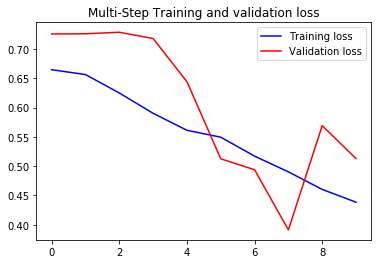

In [16]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


In [17]:
multi_step_model.save('../models/LSTM_benchmark_model_valve_leakage_10epoch.h5') 

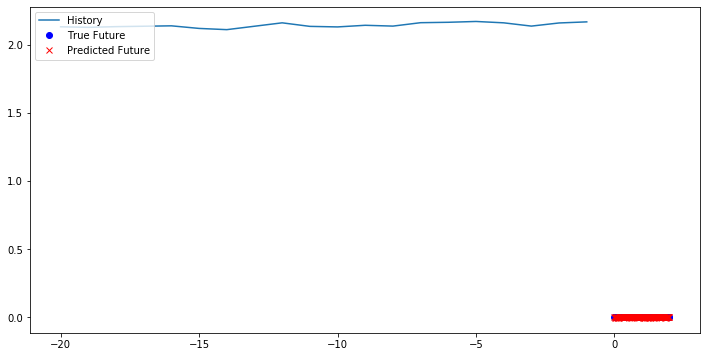

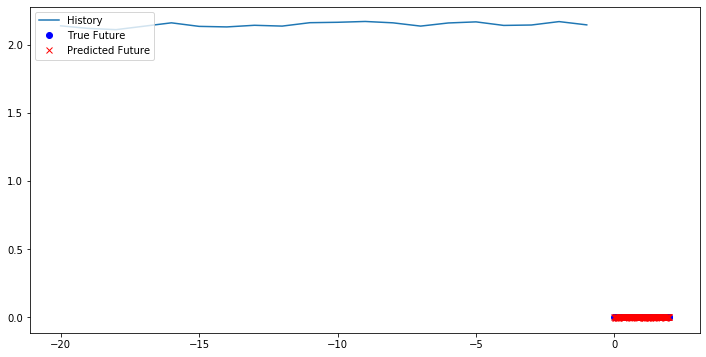

In [19]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

for x, y in val_data_multi.take(2):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
